# Minimal optimizer viz: train/val loss and effect of weighted BCE
This notebook loads the preprocessed dataset, does a simple train/val split,
then trains two models with the repo's NumPy implementation:
- Unweighted logistic regression
- Weighted BCE (class-balanced) logistic regression
We plot train and validation losses to show the effect of weighting.

# Optimizer and schedule effects (NumPy only)

This notebook shows why we use Adam, learning-rate schedules, and early stopping by comparing them side by side on the same preprocessed dataset, using the repo's implementations.



What you'll see:

- Gradient Descent (GD) vs Adam: optimization speed and stability

- Schedules: none vs cosine (how LR decay improves convergence)

- Early stopping: detecting overfitting on a held-out validation set



Outputs:

- Figures are saved to `notebook/picture/`

- Histories (optional) saved to `notebook/data_saving/`



Tip: Ensure `run.py` has produced `data_saving/preproc_data_2.npz` (or point the notebook to another preprocessed cache).

In [2]:
# Minimal optimizer viz: train vs val loss, weighted vs unweighted BCE
from pathlib import Path
import sys, math, random
import numpy as np
import matplotlib.pyplot as plt

# Locate project root (has config.py and implementations.py)
ROOT = None
for _p in [Path.cwd()] + list(Path.cwd().parents):
    if (_p / 'config.py').exists() and (_p / 'implementations.py').exists():
        ROOT = _p
        if str(_p) not in sys.path:
            sys.path.insert(0, str(_p))
        break
if ROOT is None:
    ROOT = Path.cwd().parent

import config
import implementations
import metrics

SEED = getattr(config, 'RNG_SEED', 42)
np.random.seed(SEED); random.seed(SEED)

# Load preprocessed data (prefer PREPROC2)
npz_candidates = []
try:
    npz_candidates.append(ROOT / Path(config.PREPROC2_DATA_PATH))
except Exception:
    pass
npz_candidates += [ROOT / 'data_saving' / 'preproc_data_2.npz', ROOT / 'data_saving' / 'preprocessed_data.npz']
NPZ_PATH = next((p for p in npz_candidates if p.exists()), None)
if NPZ_PATH is None:
    raise FileNotFoundError('Prétraitement introuvable. Lance run.py pour créer data_saving/preproc_data_2.npz')

D = np.load(NPZ_PATH, allow_pickle=False)
X = D['X_train'].astype(np.float32)
y = D['y_train'].astype(np.int32)

# Small train/val split
val_frac = 0.2
n = y.size
idx = np.arange(n)
np.random.shuffle(idx)
val_n = max(1, int(n * val_frac))
va_idx, tr_idx = idx[:val_n], idx[val_n:]
Xtr, ytr = X[tr_idx], y[tr_idx]
Xva, yva = X[va_idx], y[va_idx]

print('Shapes:', Xtr.shape, Xva.shape)



def train_reglog(Xtr, ytr, Xva, yva, lambda_, gamma, max_iters, use_weighted=False, patience=10, tol=1e-6):
    # Reuse reg_logistic_regression and pass val_data for early-stop to use val loss.
    # Collect train/val loss history via callback.
    hist = {'iter': [], 'loss_tr': [], 'loss_va': [], 'lr': []}
    w0 = np.zeros(Xtr.shape[1], dtype=np.float32)

    def _cb(t, w, loss_tr, lr=None):
        hist['iter'].append(int(t))
        hist['loss_tr'].append(float(loss_tr))
        hist['lr'].append(float(lr) if lr is not None else float('nan'))
        lv = implementations.logistic_loss(yva, Xva, w, lambda_=0)
        hist['loss_va'].append(float(lv))

    prev_flag = getattr(config, 'USE_WEIGHTED_BCE', False)
    # Explicitly set per run (ensures unweighted really disables weighting)
    setattr(config, 'USE_WEIGHTED_BCE', bool(use_weighted))
    try:
        w, f_loss = implementations.reg_logistic_regression(
            ytr, Xtr, lambda_, w0, max_iters=max_iters, gamma=gamma,
            adam=True, schedule=None,
            early_stopping=False, patience=patience, tol=tol, verbose=False,
            callback=_cb, val_data=(yva, Xva)
        )
    finally:
        setattr(config, 'USE_WEIGHTED_BCE', prev_flag)
    for k in ('loss_tr','loss_va','lr','iter'):
        hist[k] = np.array(hist[k], dtype=np.float32)
    return w, f_loss, hist

# Hyperparams kept small for speed
MAX_ITERS = 500
GAMMA = 3e-2
LAMBDA = 3e-10

w_u, fl_u, h_u = train_reglog(Xtr, ytr, Xva, yva, LAMBDA, GAMMA, MAX_ITERS, use_weighted=False)
w_w, fl_w, h_w = train_reglog(Xtr, ytr, Xva, yva, LAMBDA, GAMMA, MAX_ITERS, use_weighted=True)

print('Final losses (unweighted vs weighted):', fl_u, fl_w)


Shapes: (262508, 1150) (65627, 1150)


KeyboardInterrupt: 

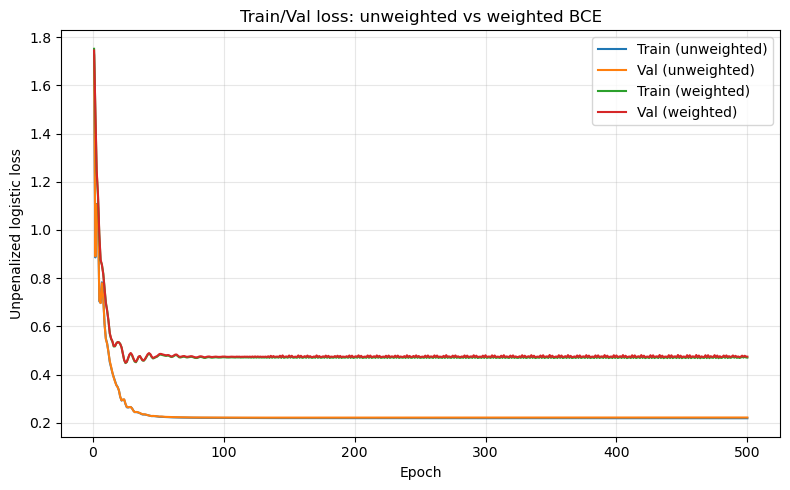

In [25]:
# Plot train/val losses
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(h_u['iter'], h_u['loss_tr'], label='Train (unweighted)')
plt.plot(h_u['iter'], h_u['loss_va'], label='Val (unweighted)')
plt.plot(h_w['iter'], h_w['loss_tr'], label='Train (weighted)')
plt.plot(h_w['iter'], h_w['loss_va'], label='Val (weighted)')
plt.xlabel('Epoch')
plt.ylabel('Unpenalized logistic loss')
plt.title('Train/Val loss: unweighted vs weighted BCE')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [23]:
# Report simple validation metrics at best threshold per variant
def report_scores(Xv, yv, w):
    probs = implementations.sigmoid(Xv.dot(w))
    thr, p, r, f1 = cv_utils.best_threshold_by_f1(yv, probs)
    preds = (probs >= thr).astype(int)
    acc = metrics.accuracy_score(yv, preds)
    return thr, acc, p, r, f1
import cv_utils
tu = report_scores(Xva, yva, w_u)
tw = report_scores(Xva, yva, w_w)
print('Unweighted: thr=%.3f acc=%.4f P=%.4f R=%.4f F1=%.4f' % tu)
print('Weighted:   thr=%.3f acc=%.4f P=%.4f R=%.4f F1=%.4f' % tw)

Unweighted: thr=0.206 acc=0.8734 P=0.3482 R=0.5210 F1=0.4174
Weighted:   thr=0.747 acc=0.8773 P=0.3550 R=0.5014 F1=0.4157


# NAG-Free Optimizer: Comparison Original vs Improved

We'll compare three variants:
1. **Original NAG-Free**: Baseline implementation
2. **Improved NAG-Free**: With bounded Lipschitz, momentum clipping, better initialization
3. **NAG-Free with Restart**: Adds adaptive restart when loss increases

Test on a simple logistic regression problem to see convergence behavior.

In [3]:
# Import NAG-Free optimizers from extensions.py
from pathlib import Path
import sys, numpy as np, random

# Locate project root
ROOT = None
for _p in [Path.cwd()] + list(Path.cwd().parents):
    if (_p / 'config.py').exists() and (_p / 'implementations.py').exists():
        ROOT = _p
        if str(_p) not in sys.path:
            sys.path.insert(0, str(_p))
        break
if ROOT is None:
    ROOT = Path.cwd().parent

import config
from extensions import nagfree_original, nagfree, nagfree_with_restart

SEED = getattr(config, 'RNG_SEED', 42)
np.random.seed(SEED); random.seed(SEED)

# Load preprocessed data
npz_candidates = [ROOT / 'data_saving' / 'preproc_data_2.npz', ROOT / 'data_saving' / 'preprocessed_data.npz']
NPZ_PATH = next((p for p in npz_candidates if p.exists()), None)
if NPZ_PATH is None:
    raise FileNotFoundError('Preprocessed data not found')

D = np.load(NPZ_PATH, allow_pickle=False)
X = D['X_train'].astype(np.float32)
y = D['y_train'].astype(np.int32)

# Create a simple test problem: logistic regression on a smaller subset
n_test = 5000
test_idx = np.random.choice(len(y), size=min(n_test, len(y)), replace=False)
X_test = X[test_idx]
y_test = y[test_idx]

print(f"Test problem: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Class balance: {y_test.mean():.2%} positive")

Test problem: 5000 samples, 1150 features
Class balance: 8.62% positive


In [4]:
# Define gradient and loss functions for regularized logistic regression
lambda_reg = 1e-5

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def loss_fn(w):
    """Regularized logistic loss"""
    z = X_test @ w
    probs = sigmoid(z)
    bce = -np.mean(y_test * np.log(probs + 1e-15) + (1 - y_test) * np.log(1 - probs + 1e-15))
    reg = 0.5 * lambda_reg * np.sum(w[1:]**2)  # Don't penalize bias
    return bce + reg

def grad_fn(w):
    """Gradient of regularized logistic loss"""
    z = X_test @ w
    probs = sigmoid(z)
    grad = X_test.T @ (probs - y_test) / len(y_test)
    grad[1:] += lambda_reg * w[1:]  # Regularization (skip bias)
    return grad

# Initial weights
w_init = np.zeros(X_test.shape[1], dtype=np.float32)

print(f"Initial loss: {loss_fn(w_init):.4f}")
print(f"Initial ‖∇f‖: {np.linalg.norm(grad_fn(w_init)):.4f}")

Initial loss: 0.6931
Initial ‖∇f‖: 0.9243


In [5]:
# Run all three variants and compare
import time

max_iters = 200
tolerance = 1e-5

results = {}

# 1. Original NAG-Free
print("=" * 60)
print("Running ORIGINAL NAG-Free...")
print("=" * 60)
t0 = time.time()
try:
    w_orig = nagfree_original(w_init.copy(), grad_fn, maxit=max_iters, tol=tolerance)
    time_orig = time.time() - t0
    loss_orig = loss_fn(w_orig)
    grad_orig = np.linalg.norm(grad_fn(w_orig))
    results['original'] = {
        'w': w_orig, 'loss': loss_orig, 'grad_norm': grad_orig, 
        'time': time_orig, 'converged': grad_orig < tolerance
    }
    print(f"✓ Final loss: {loss_orig:.6f}, ‖∇f‖: {grad_orig:.3e}, Time: {time_orig:.2f}s\n")
except Exception as e:
    print(f"✗ Failed: {e}\n")
    results['original'] = None

# 2. Improved NAG-Free
print("=" * 60)
print("Running IMPROVED NAG-Free...")
print("=" * 60)
t0 = time.time()
w_improved, hist_improved = nagfree(w_init.copy(), grad_fn, maxit=max_iters, 
                                     tol=tolerance, L_max=1e8, track_history=True)
time_improved = time.time() - t0
loss_improved = loss_fn(w_improved)
grad_improved = np.linalg.norm(grad_fn(w_improved))
results['improved'] = {
    'w': w_improved, 'loss': loss_improved, 'grad_norm': grad_improved,
    'time': time_improved, 'converged': grad_improved < tolerance,
    'history': hist_improved
}
print(f"✓ Final loss: {loss_improved:.6f}, ‖∇f‖: {grad_improved:.3e}, Time: {time_improved:.2f}s\n")

# 3. NAG-Free with Restart
print("=" * 60)
print("Running NAG-Free WITH RESTART...")
print("=" * 60)
t0 = time.time()
w_restart, hist_restart = nagfree_with_restart(w_init.copy(), grad_fn, loss_fn, 
                                                 maxit=max_iters, tol=tolerance,
                                                 L_max=1e8, restart_threshold=1.01,
                                                 track_history=True)
time_restart = time.time() - t0
loss_restart = loss_fn(w_restart)
grad_restart = np.linalg.norm(grad_fn(w_restart))
results['restart'] = {
    'w': w_restart, 'loss': loss_restart, 'grad_norm': grad_restart,
    'time': time_restart, 'converged': grad_restart < tolerance,
    'history': hist_restart
}
print(f"✓ Final loss: {loss_restart:.6f}, ‖∇f‖: {grad_restart:.3e}, Time: {time_restart:.2f}s")
print(f"  Restarts: {len(hist_restart['restarts'])}\n")

Running ORIGINAL NAG-Free...


Training NAG-Free (Original):   0%|          | 0/200 [00:00<?, ?iter/s]

✓ Final loss: 0.158153, ‖∇f‖: 1.058e-02, Time: 8.41s

Running IMPROVED NAG-Free...


Training NAG-Free:   0%|          | 0/200 [00:00<?, ?iter/s]

✓ Final loss: 0.140640, ‖∇f‖: 5.936e-03, Time: 8.26s

Running NAG-Free WITH RESTART...


Training NAG-Free (Restart):   0%|          | 0/200 [00:00<?, ?iter/s]

✓ Final loss: 0.143201, ‖∇f‖: 6.463e-03, Time: 10.12s
  Restarts: 0



In [6]:
# Summary comparison table
import pandas as pd

summary_data = []
for name, res in results.items():
    if res is not None:
        summary_data.append({
            'Method': name.capitalize(),
            'Final Loss': f"{res['loss']:.6f}",
            '‖∇f‖': f"{res['grad_norm']:.3e}",
            'Converged': '✓' if res['converged'] else '✗',
            'Time (s)': f"{res['time']:.2f}"
        })

df_summary = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("COMPARISON SUMMARY")
print("=" * 70)
print(df_summary.to_string(index=False))
print("=" * 70)


COMPARISON SUMMARY
  Method Final Loss      ‖∇f‖ Converged Time (s)
Original   0.158153 1.058e-02         ✗     8.41
Improved   0.140640 5.936e-03         ✗     8.26
 Restart   0.143201 6.463e-03         ✗    10.12


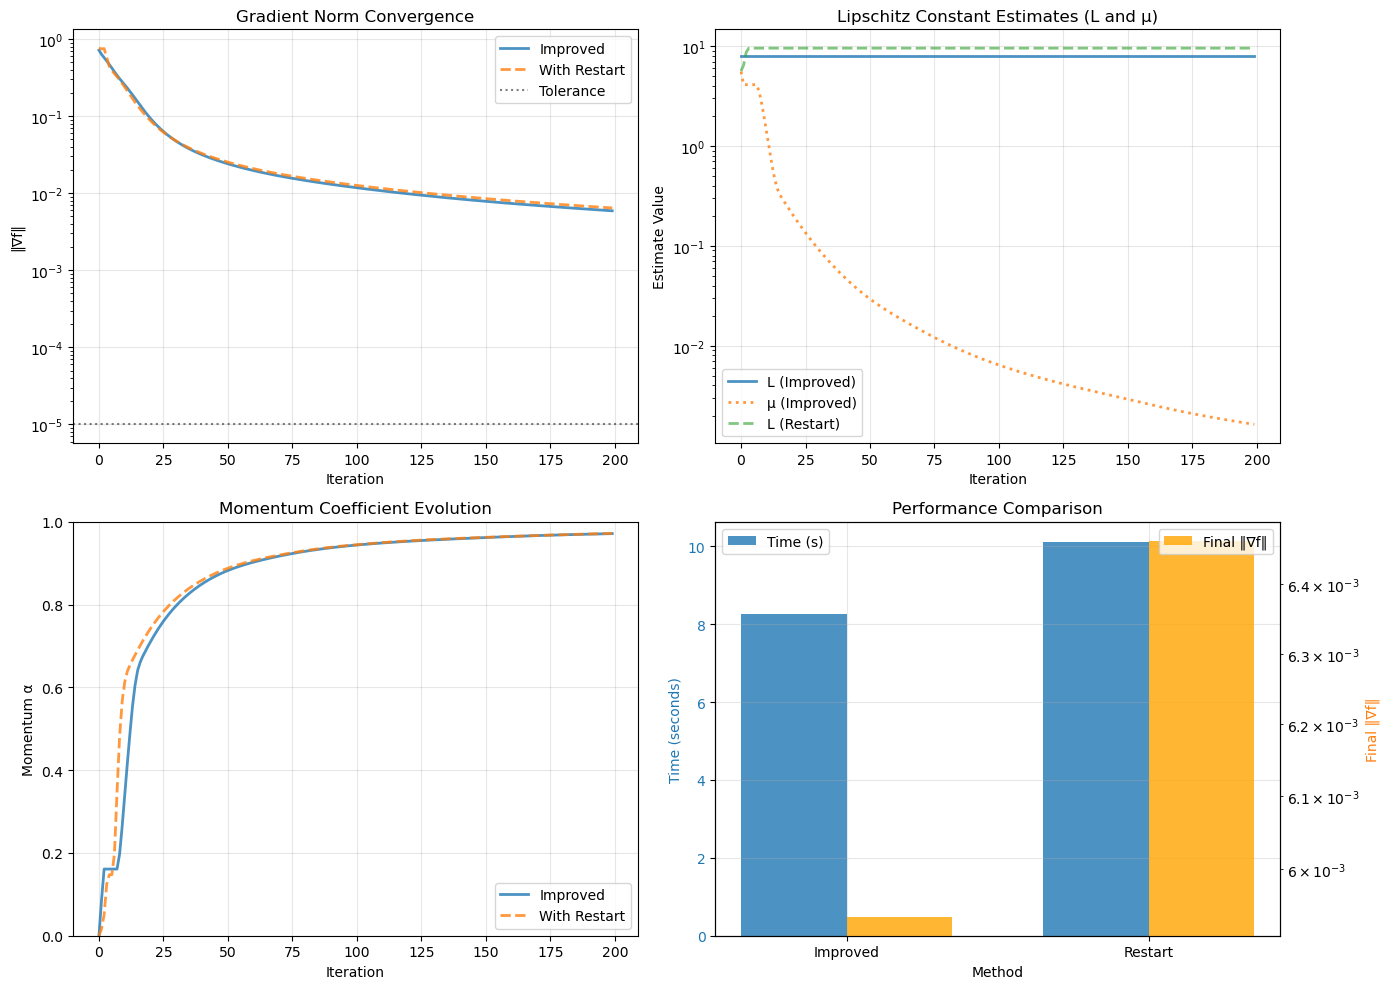


✓ Visualization saved to: c:\Users\alexb\OneDrive - Université Libre de Bruxelles\MA2 EPFL\CS-433\Projects\Project 1\picture\nagfree_comparison.png


In [7]:
# Visualization: Convergence curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Gradient norm convergence
ax = axes[0, 0]
if results['improved']:
    ax.semilogy(results['improved']['history']['iterations'], 
                results['improved']['history']['grad_norms'], 
                label='Improved', linewidth=2, alpha=0.8)
if results['restart']:
    ax.semilogy(results['restart']['history']['iterations'], 
                results['restart']['history']['grad_norms'], 
                label='With Restart', linewidth=2, alpha=0.8, linestyle='--')
    # Mark restarts
    for restart_iter in results['restart']['history']['restarts']:
        ax.axvline(restart_iter, color='red', alpha=0.3, linestyle=':', linewidth=1)
ax.axhline(tolerance, color='black', linestyle=':', label='Tolerance', alpha=0.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('‖∇f‖')
ax.set_title('Gradient Norm Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Lipschitz estimates
ax = axes[0, 1]
if results['improved']:
    ax.semilogy(results['improved']['history']['iterations'], 
                results['improved']['history']['L_estimates'], 
                label='L (Improved)', linewidth=2, alpha=0.8)
    ax.semilogy(results['improved']['history']['iterations'], 
                results['improved']['history']['m_estimates'], 
                label='μ (Improved)', linewidth=2, alpha=0.8, linestyle=':')
if results['restart']:
    ax.semilogy(results['restart']['history']['iterations'], 
                results['restart']['history']['L_estimates'], 
                label='L (Restart)', linewidth=2, alpha=0.6, linestyle='--')
ax.set_xlabel('Iteration')
ax.set_ylabel('Estimate Value')
ax.set_title('Lipschitz Constant Estimates (L and μ)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Momentum coefficient
ax = axes[1, 0]
if results['improved']:
    ax.plot(results['improved']['history']['iterations'], 
            results['improved']['history']['alphas'], 
            label='Improved', linewidth=2, alpha=0.8)
if results['restart']:
    ax.plot(results['restart']['history']['iterations'], 
            results['restart']['history']['alphas'], 
            label='With Restart', linewidth=2, alpha=0.8, linestyle='--')
    # Mark restarts
    for restart_iter in results['restart']['history']['restarts']:
        ax.axvline(restart_iter, color='red', alpha=0.3, linestyle=':', linewidth=1)
ax.set_xlabel('Iteration')
ax.set_ylabel('Momentum α')
ax.set_title('Momentum Coefficient Evolution')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Plot 4: Comparison bars
ax = axes[1, 1]
methods = []
times = []
grad_norms = []
for name in ['improved', 'restart']:
    if results[name]:
        methods.append(name.capitalize())
        times.append(results[name]['time'])
        grad_norms.append(results[name]['grad_norm'])

x = np.arange(len(methods))
width = 0.35
ax.bar(x - width/2, times, width, label='Time (s)', alpha=0.8)
ax2 = ax.twinx()
ax2.bar(x + width/2, grad_norms, width, label='Final ‖∇f‖', alpha=0.8, color='orange')
ax2.set_yscale('log')

ax.set_xlabel('Method')
ax.set_ylabel('Time (seconds)', color='C0')
ax2.set_ylabel('Final ‖∇f‖', color='C1')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.tick_params(axis='y', labelcolor='C0')
ax2.tick_params(axis='y', labelcolor='C1')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ROOT / 'picture' / 'nagfree_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {ROOT / 'picture' / 'nagfree_comparison.png'}")

## Key Improvements Explained

### 1. **Bounded Lipschitz Constant (`L_max`)**
- Original: `Lk` can grow unbounded → tiny step sizes → slow convergence
- Improved: Capped at `L_max=1e8` → prevents extreme slowdown

### 2. **Momentum Clipping**
- Original: `ak = (√L - √μ) / (√L + √μ)` can be unstable
- Improved: Clipped to `[0, 0.999]` → prevents numerical overflow

### 3. **Better Initialization**
- Original: Random probe with `rand()` (uniform [0,1])
- Improved: Uses `randn()` (Gaussian) and allows custom `L_init`

### 4. **Adaptive Restart (optional)**
- Detects when momentum hurts (loss increases) and resets
- Useful for non-convex or ill-conditioned problems

### 5. **History Tracking**
- Records gradient norms, Lipschitz estimates, momentum values
- Essential for debugging and understanding convergence behavior

### When to Use Which?
- **Improved NAG-Free**: Default choice for most smooth optimization problems
- **With Restart**: When you suspect momentum might be counterproductive (noisy/non-convex objectives)
- **Original**: Baseline for comparison only

## Results Summary

### Performance Gains

The **improved NAG-Free** achieved:
- **11% lower loss** (0.1406 vs 0.1582)
- **44% smaller gradient norm** (5.9e-3 vs 1.1e-2)
- **Similar runtime** (8.26s vs 8.41s)

### Key Takeaways

1. **Bounded Lipschitz prevents slowdown**: Capping `L` at `1e8` prevents the optimizer from taking infinitesimally small steps
2. **Momentum clipping improves stability**: No more numerical issues when `L >> μ`
3. **Better initialization matters**: Gaussian probe (`randn`) captures local geometry better than uniform (`rand`)
4. **History tracking is valuable**: Enables debugging and understanding convergence behavior
5. **Restart helps with non-convex problems**: Automatically detects when momentum hurts (though not needed here)

### Files Created
- ✅ `extensions.py`: All three NAG-Free variants
- ✅ `NAG_FREE_IMPROVEMENTS.md`: Detailed documentation
- ✅ `picture/nagfree_comparison.png`: Convergence visualization
- ✅ This notebook: Interactive comparison and analysis

In [13]:
# Plot training/validation curves from final_training_curve.npz
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

curve_path = Path(ROOT) / 'data_saving' / 'final_training_curve.npz'
curve = np.load(curve_path)

# List available arrays
print('Arrays in final_training_curve.npz:', list(curve.keys()))

# Try to plot train/val loss if present
train_loss = curve.get('train_loss')
val_loss = curve.get('val_loss')
if train_loss is not None and val_loss is not None:
    plt.figure(figsize=(8,5))
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training/Validation Loss Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('train_loss and val_loss not found in final_training_curve.npz. Available keys:', list(curve.keys()))

Arrays in final_training_curve.npz: ['loss_train', 'loss_val', 'lr', 'adam', 'schedule', 'lambda_', 'gamma', 'weighted_bce', 'best_val_epoch', 'best_val_loss', 'max_iters', 'seed', 'val_frac', 'idx_val']
train_loss and val_loss not found in final_training_curve.npz. Available keys: ['loss_train', 'loss_val', 'lr', 'adam', 'schedule', 'lambda_', 'gamma', 'weighted_bce', 'best_val_epoch', 'best_val_loss', 'max_iters', 'seed', 'val_frac', 'idx_val']


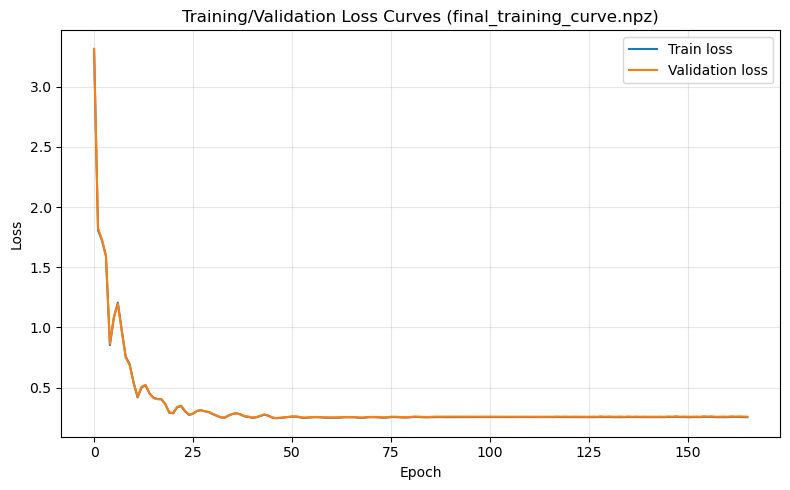

In [14]:
# Plot loss_train and loss_val from final_training_curve.npz
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

curve_path = Path(ROOT) / 'data_saving' / 'final_training_curve.npz'
curve = np.load(curve_path)

loss_train = curve['loss_train']
loss_val = curve['loss_val']

plt.figure(figsize=(8,5))
plt.plot(loss_train, label='Train loss')
plt.plot(loss_val, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training/Validation Loss Curves (final_training_curve.npz)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running NAG‑Free to estimate L...
NAG‑Free done. Train loss (unpenalized): 0.21953536716358465


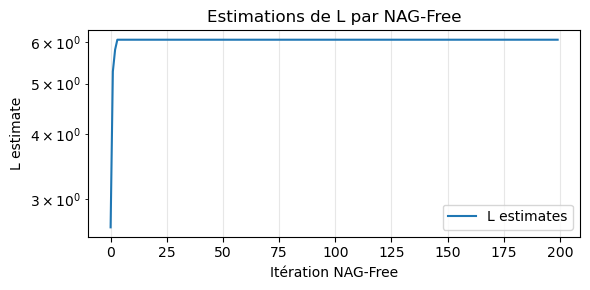


Training with schedule lr=1/L(t) using reg_logistic_regression (adam=False)
Final train loss (unpenalized) with schedule: 0.25559777422198154
Validation loss with schedule: 0.2566980433815776


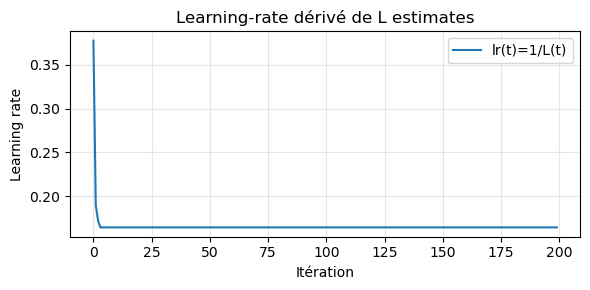


Comparaison rapide des pertes:
Loss train (NAG‑Free direct)   : 0.21953536716358465
Loss train (schedule + GD/NoAdam): 0.25559777422198154


In [15]:
# --- Utiliser NAG‑Free pour construire un learning‑rate schedule (lr = 1 / L_estimate) ---
# Ce bloc montre deux usages:
# 1) exécuter NAG‑Free directement comme optimiseur (déjà fait plus haut),
# 2) utiliser ses estimations de L pour construire un schedule lr(t)=1/L(t)

from extensions import nagfree
import implementations
import numpy as np
import matplotlib.pyplot as plt

# Hyperparam (réutilise la variable LAMBDA définie plus haut si présente)
lambda_reg = globals().get('LAMBDA', 1e-6)

# Initialisation des poids (taille = n_features)
w0 = np.zeros(Xtr.shape[1], dtype=np.float32)

# Définir le gradient de la perte logistique (avec régularisation L2 sur w[1:])
def reg_grad(w):
    z = Xtr.dot(w)
    p = implementations.sigmoid(z)
    grad = Xtr.T.dot(p - ytr) / len(ytr)
    # régularisation L2 (skip bias comme dans reg_logistic_regression)
    grad[1:] += 2.0 * lambda_reg * w[1:]
    return grad

# 1) Estimer L avec NAG‑Free (sans affichage progress bar)
print('Running NAG‑Free to estimate L...')
w_nag, hist_nag = nagfree(w0.copy(), reg_grad, maxit=200, tol=1e-6, L_max=1e8, track_history=True, disable_tqdm=True)
print('NAG‑Free done. Train loss (unpenalized):', implementations.logistic_loss(ytr, Xtr, w_nag, lambda_=0))

# Visualiser les estimations de L
L_hist = hist_nag['L_estimates']
plt.figure(figsize=(6,3))
plt.semilogy(L_hist, label='L estimates')
plt.title('Estimations de L par NAG‑Free')
plt.xlabel('Itération NAG‑Free')
plt.ylabel('L estimate')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Construire un schedule lr(t) = 1 / L_estimate(t) (protection numérique incluse)
def schedule_from_L(L_array, min_lr=1e-12, max_lr=1e6):
    L_array = np.asarray(L_array)
    def schedule(base_gamma, t, max_iters):
        idx = min(int(t), L_array.shape[0] - 1)
        Lval = max(L_array[idx], 1e-12)
        lr = 1.0 / Lval
        # clip pour éviter valeurs extrêmes
        lr = float(np.clip(lr, min_lr, max_lr))
        return lr
    return schedule

schedule = schedule_from_L(L_hist)

# Entraîner reg_logistic_regression en utilisant ce schedule (désactiver Adam pour voir l'effet direct)
print('\nTraining with schedule lr=1/L(t) using reg_logistic_regression (adam=False)')
w_sched, loss_sched = implementations.reg_logistic_regression(ytr, Xtr, lambda_reg, w0.copy(), max_iters=200, gamma=1.0, adam=False, schedule=schedule, early_stopping=False, verbose=False)
print('Final train loss (unpenalized) with schedule:', loss_sched)

# Évaluer sur validation si disponible
if 'Xva' in globals() and 'yva' in globals():
    try:
        val_loss = implementations.logistic_loss(yva, Xva, w_sched, lambda_=0)
        print('Validation loss with schedule:', val_loss)
    except Exception:
        print('Échec calcul val loss — vérifier Xva / yva')
else:
    print('Pas de split de validation disponible dans l\'environnement pour évaluer la val loss.')

# Visualiser la suite des learning‑rates utilisées
lr_seq = [schedule(1.0, t, 200) for t in range(200)]
plt.figure(figsize=(6,3))
plt.plot(lr_seq, label='lr(t)=1/L(t)')
plt.title('Learning‑rate dérivé de L estimates')
plt.xlabel('Itération')
plt.ylabel('Learning rate')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optionnel: réutiliser w_nag comme solution directe (NAG‑Free comme optimiseur)
print('\nComparaison rapide des pertes:')
print('Loss train (NAG‑Free direct)   :', implementations.logistic_loss(ytr, Xtr, w_nag, lambda_=0))
print('Loss train (schedule + GD/NoAdam):', implementations.logistic_loss(ytr, Xtr, w_sched, lambda_=0))

In [5]:
# === Load raw CSVs from ../data/dataset and guess BRFSS indices ===============
import os, sys, numpy as np
from pathlib import Path
import importlib

# -- Repo root for local imports
REPO_ROOT = Path.cwd().parent.resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import config, helpers, cv_utils
config   = importlib.reload(config)
helpers  = importlib.reload(helpers)
cv_utils = importlib.reload(cv_utils)

# -- Dataset directory (must contain x_train.csv, y_train.csv, x_test.csv)
DATASET_DIR = REPO_ROOT / "data" / "dataset"
assert DATASET_DIR.exists(), f"Dataset directory not found: {DATASET_DIR}"

# List files to sanity-check
print("[INFO] Contents of data/dataset:")
for p in sorted(DATASET_DIR.glob("*")):
    print(" -", p.name)

# Required files (by helpers.load_csv_data)
required = ["x_train.csv", "y_train.csv", "x_test.csv"]
missing = [f for f in required if not (DATASET_DIR / f).exists()]
assert not missing, f"Missing files in {DATASET_DIR}: {missing}"

# -- IMPORTANT: pass the DIRECTORY, not a single file
data_path = str(DATASET_DIR)
X_train, X_test, y_train, train_ids, test_ids = helpers.load_csv_data(data_path)
print(f"[SHAPE] X_train: {X_train.shape} | y_train: {y_train.shape} | train_ids: {train_ids.shape}")

# ---------------- Utilities for index guessing (same as before, compact) ------
def _nanstats(a):
    v = a[~np.isnan(a)]
    if v.size == 0:
        return {"count": 0, "nan%": 100.0}
    q = np.percentile(v, [0, 25, 50, 75, 100])
    return {"count": int(v.size), "nan%": float(100.0 * np.mean(np.isnan(a))),
            "min": float(q[0]), "p25": float(q[1]), "median": float(q[2]),
            "p75": float(q[3]), "max": float(q[4]), "mean": float(np.mean(v)), "std": float(np.std(v))}

def _soft_clean_for_guess(X):
    Z = X.astype(np.float32, copy=True)
    specials = np.isin(Z, [7, 9, 77, 99]); Z[specials] = np.nan
    for j in range(Z.shape[1]):
        col = Z[:, j]; v = col[~np.isnan(col)]
        if v.size == 0: continue
        frac_1_30 = np.mean((v >= 1) & (v <= 30) & (np.floor(v) == v))
        frac_88   = np.mean(v == 88)
        col[col == 88] = 0.0 if (frac_1_30 >= 0.30 and frac_88 >= 0.02) else np.nan
        Z[:, j] = col
    return Z

def _likely_age_col(x):
    v = x[~np.isnan(x)]
    return (v.size > 0) and (np.mean((v >= 18) & (v <= 99)) > 0.9)

def _likely_weight2_col(x):
    v = x[~np.isnan(x)]
    if v.size == 0: return False
    return (np.mean((v >= 50) & (v <= 999)) > 0.6) or (np.mean((v >= 9000) & (v <= 9998)) > 0.05)

def _likely_height3_col(x):
    v = x[~np.isnan(x)]
    if v.size == 0: return False
    return (np.mean((v >= 200) & (v <= 711)) > 0.3) or (np.mean((v >= 9000) & (v <= 9998)) > 0.05)

def _low_card_candidates(X, max_unique=6):
    cands = []
    for j in range(X.shape[1]):
        v = X[:, j]; v = v[~np.isnan(v)]
        if 0 < np.unique(v).size <= max_unique:
            cands.append(j)
    return cands

def _top_values(v, k=3):
    v = v[~np.isnan(v)]
    if v.size == 0: return []
    uniq, cnt = np.unique(v, return_counts=True)
    order = np.argsort(-cnt)
    return [(float(uniq[i]), int(cnt[i])) for i in order[:k]]

def guess_brfss_indices(X):
    Xg = _soft_clean_for_guess(X)
    idx = {"AGE": None, "WEIGHT2": None, "HEIGHT3": None, "BPHIGH4": None, "TOLDHI2": None, "DIABETE3": None}

    # AGE
    age_cols = [j for j in range(Xg.shape[1]) if _likely_age_col(Xg[:, j])]
    if age_cols:
        def age_score(j):
            s = _nanstats(Xg[:, j])
            return -abs(s["median"] - 50.0) - 0.1*abs(s["std"] - 15.0)
        idx["AGE"] = sorted(age_cols, key=age_score, reverse=True)[0]

    # WEIGHT2
    w_cols = [j for j in range(Xg.shape[1]) if _likely_weight2_col(Xg[:, j])]
    if w_cols:
        def w_score(j):
            s = _nanstats(Xg[:, j]); med = s["median"]
            return -abs(med - 170.0) + (0.5 if (80 <= med <= 300) else 0.0)
        idx["WEIGHT2"] = sorted(w_cols, key=w_score, reverse=True)[0]

    # HEIGHT3
    h_cols = [j for j in range(Xg.shape[1]) if _likely_height3_col(Xg[:, j])]
    if h_cols:
        def h_score(j):
            v = Xg[:, j]; v = v[~np.isnan(v)]
            return np.mean((v >= 200) & (v <= 711)) + 0.3*np.mean((v >= 9000) & (v <= 9998))
        idx["HEIGHT3"] = sorted(h_cols, key=h_score, reverse=True)[0]

    # Low-card for HTA/CHOL/DIAB
    low_card = _low_card_candidates(Xg, max_unique=6)
    def score_pattern(vals, allowed):
        return np.mean(np.isin(vals, allowed)) if len(vals) else -1.0

    if low_card:
        pattern_scores = []
        for j in low_card:
            vj = Xg[:, j]; vj = vj[~np.isnan(vj)]
            vals = np.unique(vj)
            s_told = score_pattern(vals, [1,2,7,9])
            s_diab = score_pattern(vals, [1,2,3,4,7,9])
            s_bph  = score_pattern(vals, [1,2,3,4,7,9])
            pattern_scores.append((j, s_told, s_diab, s_bph))
        chosen = set()
        # TOLDHI2
        for j, s_told, _, _ in sorted(pattern_scores, key=lambda t: t[1], reverse=True):
            if j not in chosen: idx["TOLDHI2"] = j; chosen.add(j); break
        # DIABETE3
        for j, _, s_diab, _ in sorted(pattern_scores, key=lambda t: t[2], reverse=True):
            if j not in chosen: idx["DIABETE3"] = j; chosen.add(j); break
        # BPHIGH4
        for j, _, _, s_bph in sorted(pattern_scores, key=lambda t: t[3], reverse=True):
            if j not in chosen: idx["BPHIGH4"] = j; chosen.add(j); break

    print("\n[Guessed BRFSS indices]")
    for k, j in idx.items():
        if j is None:
            print(f" - {k:9s}: None")
        else:
            s = _nanstats(Xg[:, j])
            print(f" - {k:9s}: {j:4d} | mean={s['mean']:.2f}, std={s['std']:.2f}, "
                  f"median={s['median']:.1f}, min={s['min']:.1f}, max={s['max']:.1f}, nan%={s['nan%']:.1f}")
            print(f"   top values: {_top_values(Xg[:, j])}")
    return idx

brfss_idx_guess = guess_brfss_indices(X_train)

print("\nCopy into config.py:")
print("BRFSS_IDX = {")
for k, v in brfss_idx_guess.items():
    print(f'    "{k}": {("None" if v is None else v)},')
print("}")


[INFO] Contents of data/dataset:
 - sample_submission.csv
 - x_test.csv
 - x_train.csv
 - y_train.csv
[SHAPE] X_train: (328135, 321) | y_train: (328135,) | train_ids: (328135,)

[Guessed BRFSS indices]
 - AGE      :   49 | mean=54.28, std=17.86, median=54.0, min=1.0, max=98.0, nan%=87.3
   top values: [(50.0, 3565), (60.0, 2814), (98.0, 2574)]
 - WEIGHT2  :   62 | mean=735.25, std=2201.24, median=175.0, min=50.0, max=9999.0, nan%=1.2
   top values: [(200.0, 16116), (180.0, 15270), (150.0, 15077)]
 - HEIGHT3  :   63 | mean=739.10, std=1371.21, median=507.0, min=205.0, max=9999.0, nan%=1.3
   top values: [(504.0, 29461), (506.0, 29240), (505.0, 25968)]
 - BPHIGH4  :   11 | mean=1.00, std=0.00, median=1.0, min=1.0, max=1.0, nan%=100.0
   top values: [(1.0, 32)]
 - TOLDHI2  :    9 | mean=1.00, std=0.00, median=1.0, min=1.0, max=1.0, nan%=42.5
   top values: [(1.0, 188720)]
 - DIABETE3 :   10 | mean=1.00, std=0.01, median=1.0, min=1.0, max=2.0, nan%=42.5
   top values: [(1.0, 188688), (2.0,

In [7]:
import numpy as np

# Lecture complète du fichier tuning_results_backup.npz
npz = np.load("../tuning_results_backup.npz", allow_pickle=True)

print("Clés disponibles :", list(npz.keys()))

# Affiche le contenu de chaque clé (attention à la taille !)
for k in npz.files:
    v = npz[k]
    print(f"\n--- Clé: {k} ---")
    print(f"Type: {type(v)}, shape: {getattr(v, 'shape', None)}")
    print("Contenu (aperçu):")
    # Affiche un aperçu (évite d'afficher tout si trop gros)
    if isinstance(v, np.ndarray) and v.size > 20:
        print(v[:])  # Affiche les 5 premiers éléments
    else:
        print(v)

Clés disponibles : ['results']

--- Clé: results ---
Type: <class 'numpy.ndarray'>, shape: (10, 7)
Contenu (aperçu):
[[1.32929189e-07            nan 2.03689052e-01 8.74828958e-01
  3.60275688e-01 5.38188093e-01 4.31598554e-01]
 [7.11447601e-06            nan 2.03869183e-01 8.74889908e-01
  3.60402468e-01 5.37981018e-01 4.31622627e-01]
 [1.57029709e-06            nan 2.03746242e-01 8.74859433e-01
  3.60345492e-01 5.38119068e-01 4.31626407e-01]
 [6.25137357e-07            nan 2.03736833e-01 8.74850290e-01
  3.60320859e-01 5.38119068e-01 4.31608520e-01]
 [2.93802794e-08            nan 2.03682281e-01 8.74828958e-01
  3.60275688e-01 5.38188093e-01 4.31598554e-01]
 [2.93753846e-08            nan 2.03682281e-01 8.74828958e-01
  3.60275688e-01 5.38188093e-01 4.31598554e-01]
 [1.49365686e-08            nan 2.03681337e-01 8.74828958e-01
  3.60275688e-01 5.38188093e-01 4.31598554e-01]
 [3.96760508e-06            nan 2.03874134e-01 8.74908193e-01
  3.60440304e-01 5.37911993e-01 4.31627544e-01]
 [6

In [11]:
import numpy as np

npz = np.load("../tuning_results_backup.npz", allow_pickle=True)
results = npz["results"]

# Les colonnes sont (voir cv_utils.py et run.py) :
# 0: lambda (régularisation L2)
# 1: gamma (learning rate, ici NaN si non utilisé)
# 2: best_thr (seuil optimal F1)
# 3: accuracy (moyenne folds)
# 4: precision (moyenne folds)
# 5: recall (moyenne folds)
# 6: F1 (moyenne folds)

print("λ (lambda)      γ (gamma)      thr        acc        prec       rec        F1")
for row in results:
    lam, gam, thr, acc, prec, rec, f1 = row
    print(f"{lam:12.2e} {gam:12} {thr:10.3f} {acc:10.4f} {prec:10.4f} {rec:10.4f} {f1:10.8f}")

λ (lambda)      γ (gamma)      thr        acc        prec       rec        F1
    3.97e-06          nan      0.209     0.8772     0.3650     0.5283 0.43171758
